5/26/2021
1. Check the timestamps of p2c1 and p2c2 (will be fixed by Will) done
2. read all 6 cameras (done)
3. read June data with 3 RAV4's

Current pipeline:
1. preprocess
    a. 
    preprocess_multi_camera
2. rectify
3. postprocess
    extend prediction
    add-> transform back to image
    
4. visualize on the camera video!
    dissect it to seperate cameras
    plot for each camera

In [16]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pathlib
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA

In [89]:
# read all cameras into one df
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv"):
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('*** Reading ',camera_id,'...')
            df1 = utils.preprocess(file_name, tform_path)
            df1 = df1.assign(camera=camera_id)
            df = pd.concat([df, df1])
    break
# # MUST SORT!!! OTHERWISE DIRECTION WILL BE WRONG
df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)            
print('sorted.')


*** Reading  p1c2 ...
Reading data...
212
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  210
after filtering short tracks:  189
Interpret missing timestamps...
*** Reading  p1c3 ...
Reading data...
182
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  180
after filtering short tracks:  168
Interpret missing timestamps...
*** Reading  p1c4 ...
Reading data...
151
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  148
after filtering short tracks:  137
Interpret missing timestamps...
*** Reading  p1c5 ...
Reading data...
197
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  196
after filtering short tracks:  186
Interpret missing timestamps...
*** Reading  p1c6 ...
Reading data...
209
Transf

In [19]:
# read & rectify each camera df individually
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith("p1c3"):
            
            # ... reading ...
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            
            # ... preprocessing ...
            df1 = utils.preprocess(file_name, tform_path)
            df1 = df1.assign(camera=camera_id)
            df1 = df1.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df1)
            
            # ... post processing ...
            dfpp = utils.post_process(df)
            dfpp['camera_post'] = camera_id
            dfpp_img = utils.road_to_img(dfpp, tform_path)
            
            # ... saving ...
            new_name = 'rectified_' + camera_id + '.csv'
            dfpp_img.to_csv(new_name)
    break

reading  p1c3 ...
Reading data...
182
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  180
after filtering short tracks:  168
Interpret missing timestamps...


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [01:50<00:00,  1.52it/s]


cap width at 2.59m...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [90]:
# select only one measurement from mutliple cameras per frame per ID
df = utils.preprocess_multi_camera(df)

100%|██████████████████████████████████████████████████████████████████████████████| 1797/1797 [00:18<00:00, 98.47it/s]


Get the longest continuous frame chuck...


In [92]:
import utils_optimization as opt
importlib.reload(opt)
dfre = opt.rectify(df) # parallel, batch method

100%|████████████████████████████████████████████████████████████████████████████████| 414/414 [03:46<00:00,  1.83it/s]


In [171]:
car1 = dfrep[dfrep['ID']==21150]
car2 = dfrep[dfrep['ID']==23120]

In [151]:
import time
import itertools
from itertools import combinations
from shapely.geometry import Polygon

t1 = time.time()
groups = dfre.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList)
comb = itertools.combinations(groupList, 2)
SCORE_THRESHOLD = 0
IOU = []
# id_rem = ?\[] # ID's to be removed
for c1,c2 in comb:
    car1 = groups.get_group(c1)
    car2 = groups.get_group(c2)
#     score = overlap_score(car1, car2)
    score = IOU_score(car1,car2)
    IOU.append(score)
    if score > SCORE_THRESHOLD:
        # remove the shorter track
        if len(car1)>= len(car2):
            id_rem.append(c2)
        else:
            id_rem.append(c1)
t2 = time.time()
print(t2-t1)

149.98455476760864


In [152]:
dfrre = dfre.groupby(['ID']).filter(lambda x: (x['ID'].iloc[-1] not in id_rem))

No handles with labels found to put in legend.


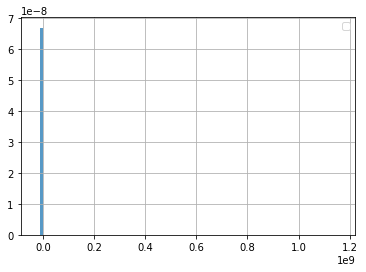

In [13]:
n, bins, patches = plt.hist(dfpp_img['bbry_re'].values, bins = 80, density=True, alpha=0.75)
# plt.xlim([-1000,8000])
plt.legend()
plt.grid(True)
plt.show()


In [158]:
import utils
importlib.reload(utils)
import utils_optimization as opt
importlib.reload(opt)

dfrep = utils.post_process(dfrre) 

cap width at 2.59m...
extending tracks to edges of the frame...
-914.3601152398504 1781.5985544863752


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:12<00:00, 22.41it/s]


In [192]:
import utils
importlib.reload(utils)
dfrep_img = utils.road_to_img(dfrep, tform_path)
# dfrep[['x']].apply(lambda x: 1 if x.all()>150 else x)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [194]:
dfrep_img.to_csv('rectified_all_img_re.csv')

In [17]:
# save file to individual cameras

import utils
importlib.reload(utils)

groups = dfrep_img.groupby('camera_post')
for camera_id, group in groups:
    file_name = 'rectified_'+camera_id+'.csv'
    group.to_csv(data_path.joinpath('rectified/' + file_name))
        


NameError: name 'dfrep_img' is not defined

In [21]:
# visualize footprint on the camera video

import plot_rectified_objects
importlib.reload(plot_rectified_objects)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
video = str(data_path.joinpath('p1c3_00000_track_outputs_corrected_3D.csv_3D.mp4'))
label_file = str(data_path.joinpath('rectified/rectify_individual_camera/rectified_p1c3.csv')) 

plot_rectified_objects.plot_rectified_objects(video,label_file,frame_rate = 10)


KeyboardInterrupt: 

In [161]:
dfrep.to_csv('rectified_all_rem_overlap.csv')

In [159]:
carre = utils.rectify(carr)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]


1  unique cars
66
ID: 1160 # frames: 66 # cameras: 1


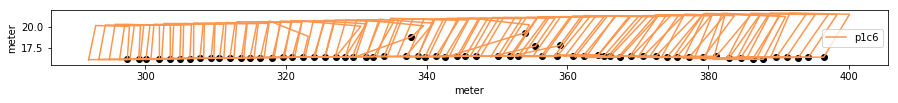

In [168]:

from matplotlib import cm
camera_list = ['p1c2','p1c3','p1c4','p1c5','p1c6','nan']
color=cm.rainbow(np.linspace(0,1,len(camera_list)))
camera_dict = dict(zip(camera_list,color))

groups = car.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')


for i in range(nO):
    ID = groupList[i]
#     if str(int(ID)) not in rav4:
#         continue
    Y1 = groups.get_group(ID)
    print(len(Y1))
    camera_group = Y1.groupby('camera')
    print('ID:',ID,'# frames:',len(Y1),'# cameras:',len(camera_group))
    fig, ax = plt.subplots(figsize=(15,1))
    
    for cameraID,cg in camera_group:
        Y = np.array(cg[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
        c=camera_dict[cameraID]
        for i in range(len(Y)):
            coord = Y[i,:]
            coord = np.reshape(coord,(-1,2)).tolist()
            coord.append(coord[0]) #repeat the first point to create a 'closed loop'
            xs, ys = zip(*coord) #lon, lat as x, y   
            plt.plot(xs,ys,c=c,label=cameraID if i == 0 else "")

        plt.scatter(Y[:,2],Y[:,3],color='black')
        ax = plt.gca()
        plt.xlabel('meter')
        plt.ylabel('meter')
        ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y) 
    plt.legend()
    plt.show()

In [169]:
import importlib
import animation_utils as an
importlib.reload(an)
image_folder = '../p1c4'
an.generate_frames(dfrre, xmin=300, xmax = 1500, ymax=120, skip_frame=2, image_folder=image_folder)

Frame:  0 1794


In [170]:
# Fetch image files from the folder, and create an animation.
importlib.reload(an)
video_name = '../p1_iou_0_allframes.mp4'
an.write_video(image_folder, video_name, fps=15)


In [309]:
car[(car['camera']=='p1c3') | (car['camera']=='p1c4')]

,Frame #,Timestamp,ID,Object class,Generation method,fbrx,fbry,fblx,fbly,bbrx,...,bbl_y,direction,camera,acceleration,speed,x,y,theta,width,length
26003,776,1.623878e+09,316120,midsize,Detector,815.415282,1726.448492,794.627638,1897.442276,417.757353,...,7.210221,1.0,p1c3,0.0,27.829598,200.121986,5.917221,0.0,2.586,4.399
26047,777,1.623878e+09,316120,midsize,Detector,889.242796,1727.254730,871.125668,1897.518602,490.979236,...,7.210221,1.0,p1c3,0.0,27.829598,201.052319,5.917221,0.0,2.586,4.399
26091,778,1.623878e+09,316120,midsize,Detector,963.156586,1727.738260,947.673450,1897.442284,562.438361,...,7.210221,1.0,p1c3,0.0,27.829598,201.982652,5.917221,0.0,2.586,4.399
26136,779,1.623878e+09,316120,midsize,Detector,1036.705636,1729.040900,1024.032360,1895.507434,633.376135,...,7.210221,1.0,p1c3,0.0,27.829598,202.912985,5.917221,0.0,2.586,4.399
26180,780,1.623878e+09,316120,midsize,Detector,1110.088502,1728.625028,1099.883786,1895.669860,708.042895,...,7.210221,1.0,p1c3,0.0,27.829598,203.843318,5.917221,0.0,2.586,4.399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39439,1127,1.623878e+09,316120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,7.210221,1.0,p1c3,0.0,27.829598,523.876341,5.917221,0.0,2.586,4.399
39488,1128,1.623878e+09,316120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,7.210221,1.0,p1c3,0.0,27.829598,524.806674,5.917221,0.0,2.586,4.399
39536,1129,1.623878e+09,316120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,7.210221,1.0,p1c3,0.0,27.829598,525.737007,5.917221,0.0,2.586,4.399
39584,1130,1.623878e+09,316120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,7.210221,1.0,p1c3,0.0,27.829598,526.667333,5.917221,0.0,2.586,4.399


In [ ]:
start = time.time()
Yre = opt.receding_horizon_opt(Y,timestamps,w,l,n,lam1,lam2,lam3,lam4,lam5,PH,IH)
end = time.time()
times_200[sec] = end-start
error_200[sec] = LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
print('time: ',times_200[sec],'error: ',error_200[sec])

No handles with labels found to put in legend.


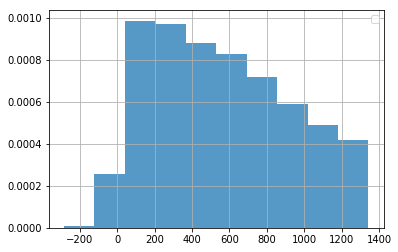

In [196]:
n, bins, patches = plt.hist(dfpp['bbr_x'].values, density=True, alpha=0.75)
plt.legend()
plt.grid(True)
plt.show()

In [188]:
# rectify all, parallelized
import utils_optimization as opt
importlib.reload(opt)
df = opt.rectify(df1)

100%|████████████████████████████████████████████████████████████████████████████████| 137/137 [01:28<00:00,  1.56it/s]


In [108]:
# filter width in post processing
import utils
importlib.reload(utils)
dfpp = utils.post_process(df)

cap width at 2.59m...


KeyError: 'width'

In [190]:
dfrep.to_csv('rectified_p1c4_rem_overlap.csv')

In [3]:
rav4 = ['316120','344120','399120']
df = df[df['ID'].isin(rav4)]
df

,Frame #,Timestamp,ID,Object class,Generation method,fbrx,fbry,fblx,fbly,bbrx,...,fbr_x,fbr_y,fbl_x,fbl_y,bbr_x,bbr_y,bbl_x,bbl_y,direction,camera
31574,682,1.623878e+09,316120,midsize,Detector,481.943103,59.449233,413.372214,87.923658,523.973558,...,118.370801,4.640242,118.611937,7.069806,113.407773,4.637416,114.659338,7.197025,1.0,p1c2
31637,683,1.623878e+09,316120,midsize,Detector,449.006480,135.117408,531.467614,113.346834,421.046074,...,119.276239,4.639320,119.516198,7.075849,114.483203,4.636621,115.739547,7.205135,1.0,p1c2
31702,684,1.623878e+09,316120,midsize,Detector,455.591760,144.571550,539.091506,122.355112,425.840834,...,120.199301,4.625674,120.438895,7.069864,115.133444,4.622839,116.466355,7.209842,1.0,p1c2
31767,685,1.623878e+09,316120,midsize,Detector,463.625642,153.194392,546.074004,131.094498,432.733262,...,121.075187,4.664432,121.308682,7.086896,116.102296,4.661514,117.236445,7.203731,1.0,p1c2
31834,686,1.623878e+09,316120,midsize,Detector,468.818226,163.550724,553.844012,140.576046,441.340920,...,122.016782,4.598994,122.254010,7.049276,117.278591,4.596456,118.688343,7.202146,1.0,p1c2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68052,1244,1.623878e+09,399120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,p1c6
68131,1245,1.623878e+09,399120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,p1c6
68209,1246,1.623878e+09,399120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,p1c6
68288,1247,1.623878e+09,399120,midsize,Detector,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,p1c6


In [119]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
from matplotlib.pyplot import cm
# group by objects

groups = car.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
nc = 2 # number of different colors
print(nO,'unique cars')

# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega

# score = np.zeros(nO) # record correction score

for i in range(nO): # for each car object
    ID = groupList[i]
#     ID = 22261
    Y = groups.get_group(ID)
    color=cm.rainbow(np.linspace(0,1,nc))
    camera_group = Y.groupby('camera')
    nC = len(camera_group)
    cgList = list(camera_group.groups)
    Y1list = []
    Yrelist = []

    for cgi in range(nC):
        cameraID = cgList[cgi]
#         cameraID = 'p2c1'
        Y1 = camera_group.get_group(cameraID)
        # impute missing timestamps
        timestamps = Y1['Timestamp'].values
        timestamps= utils.nan_helper(timestamps)
        dt = np.diff(timestamps)
        # get bottom 4 points coordinates
        Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
        
        # Euler forward dynamics
        start = time.time()
        N = len(Y1) 
        notNan = ~np.isnan(np.sum(Y1,axis=-1))
        Y1 = Y1[notNan,:]
        Y1list.append(Y1)
        a0 = np.zeros((N))
        theta0 = np.zeros((N))
        v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
        x0 = (Y1[0,0]+Y1[0,6])/2
        y0 = (Y1[0,1]+Y1[0,7])/2
        X0 = np.concatenate((a0.T, theta0.T, \
                             [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                              np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
        bnds = [(-5,5) for i in range(0,N)]+\
            [(-np.pi/8,np.pi/8) for i in range(N)]+\
            [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

        # Constraints definition (only for COBYLA, SLSQP and trust-constr)
        res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                        bounds=bnds, options={'disp': False,'maxiter':100000})#
        end = time.time()
        # extract results
        Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
        Yrelist.append(Yre)
#         print('ID:',ID, 'N:',N, 'runtime:',end - start,'\n width:',w,'length:',l)

        print('ID:',ID, 'Valid/total timestamps:',N, '/',np.count_nonzero(notNan),\
              'runtime:',end - start,'\n width:',w,'length:',l,'score:',LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)) 
    
    # plot 
    fig, ax = plt.subplots(figsize=(15,1))
    for cgi in range(nC):
        D = Y1list[cgi]
        cameraID = cgList[cgi]
        c=color[cgi%nc]
        for i in range(len(D)):
            coord = D[i,:]
            coord = np.reshape(coord,(-1,2)).tolist()
            coord.append(coord[0]) #repeat the first point to create a 'closed loop'
            xs, ys = zip(*coord) #lon, lat as x, y
            plt.plot(xs,ys,c=c,label=cameraID if i == 0 else "")
        plt.scatter(D[:,2],D[:,3],color='black')
        ax = plt.gca()
        plt.xlabel('meter')
        plt.ylabel('meter')
        ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.legend()
    plt.show() 
    
    fig, ax = plt.subplots(figsize=(15,1))
    for cgi in range(nC):
        D = Yrelist[cgi]
        cameraID = cgList[cgi]
        c=color[cgi%nc]
        for i in range(len(D)):
            coord = D[i,:]
            coord = np.reshape(coord,(-1,2)).tolist()
            coord.append(coord[0]) #repeat the first point to create a 'closed loop'
            xs, ys = zip(*coord) #lon, lat as x, y
            plt.plot(xs,ys,c=c,label=cameraID if i == 0 else "")
        plt.scatter(D[:,2],D[:,3],color='black')
        ax = plt.gca()
        plt.xlabel('meter')
        plt.ylabel('meter')
        ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.legend()
    plt.show() 

1 unique cars


AttributeError: module 'utils' has no attribute 'nan_helper'

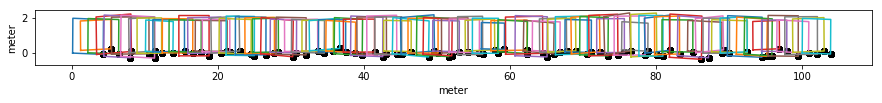

In [5]:
# generate synthetic data

D = Y1

fig, ax = plt.subplots(figsize=(15,1))
for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
        

In [131]:
# Batch optimization
# parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega
fps = 30
num_secs = np.linspace(1,300,20)
ns = np.zeros(len(num_secs))
times = np.zeros(len(num_secs))
error = np.zeros(len(num_secs))

for sec in range(len(num_secs)):
    num_sec = num_secs[sec]

    n = int(num_sec*fps)
    timestamps, Y1 = opt.create_synth_data(n)

    start = time.time()

    N = len(Y1) 
    notNan = ~np.isnan(np.sum(Y1,axis=-1))
    Y1 = Y1[notNan,:]
    dt = np.diff(timestamps)

    a0 = np.zeros((N))
    theta0 = np.zeros((N))
    v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
    x0 = (Y1[0,0]+Y1[0,6])/2
    y0 = (Y1[0,1]+Y1[0,7])/2
    X0 = np.concatenate((a0.T, theta0.T, \
                         [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                          np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
    bnds = [(-5,5) for ii in range(0,N)]+\
        [(-np.pi/8,np.pi/8) for ii in range(N)]+\
        [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

    res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                    bounds=bnds, options={'disp': False,'maxiter':100000})#
    end = time.time()
    times[sec] = end-start
    
    # extract results
    Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
    error[sec] = LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('number of seconds',num_sec,'Valid timestamps:',N,\
          'runtime:',end - start,'\n width:',w,'length:',l,'score:',LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)) 

    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
        plt.scatter(D[:,2],D[:,3],color='black')
        ax = plt.gca()
        plt.xlabel('meter')
        plt.ylabel('meter')
        ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show()
        
    D = Yre
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
        plt.scatter(D[:,2],D[:,3],color='black')
        ax = plt.gca()
        plt.xlabel('meter')
        plt.ylabel('meter')
        ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show()

numer of seconds 1.0 Valid timestamps: 30 runtime: 0.24336767196655273 
 width: 2.0118810332091286 length: 3.984589713358654 score: 12.75686687947747
numer of seconds 16.736842105263158 Valid timestamps: 502 runtime: 20.001253843307495 
 width: 1.9845208901359461 length: 4.011329865761418 score: 0.028551524937819615
numer of seconds 32.473684210526315 Valid timestamps: 974 runtime: 33.066850662231445 
 width: 1.9972692571504713 length: 4.011863748189286 score: 0.021604405940353875
numer of seconds 48.21052631578947 Valid timestamps: 1446 runtime: 58.83796763420105 
 width: 2.0103201572072695 length: 4.012956708421136 score: 0.017648247512854893
numer of seconds 63.94736842105263 Valid timestamps: 1918 runtime: 57.646167278289795 
 width: 2.001862448730936 length: 4.0071704219154665 score: 0.014826795214996228
numer of seconds 79.68421052631578 Valid timestamps: 2390 runtime: 88.23941826820374 
 width: 2.0018981316905498 length: 3.998327554124369 score: 0.013199587660039747
numer of sec

In [142]:
# get a sense of runtime vs. #frames total
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)

# try a receding horizon approach
PH = 200 # optimize over Prediction Horizon frames
IH = 100 # implementation horizon

fps = 30
num_secs = np.linspace(1,300,20)
times_200 = np.zeros(len(num_secs))
error_200 = np.zeros(len(num_secs))

for sec in range(len(num_secs)):
    num_sec = num_secs[sec]
    # generate synthetic data
    n = int(num_sec*fps) # frames
    print(n)
    if (n<IH):
        times_100[sec] = 0
        error_100[sec] = 0
        continue
    timestamps, Y = opt.create_synth_data(n)
    notNan = ~np.isnan(np.sum(Y,axis=-1))

    w,l = opt.estimate_dimensions(Y[:100,:],timestamps[:100],lam1,lam2,lam3,lam4,lam5) # use some data to estimate vehicle dimensions
    print('estimated w:',w,'l:',l)

    start = time.time()
    Yre = opt.receding_horizon_opt(Y,timestamps,w,l,n,lam1,lam2,lam3,lam4,lam5,PH,IH)
    end = time.time()
    times_200[sec] = end-start
    error_200[sec] = LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('time: ',times_200[sec],'error: ',error_200[sec])


30
502
estimated w: 1.998513212685446 l: 3.961215098851152
time:  9.371170043945312 error:  0.030917113236006624
974
estimated w: 2.0044665533127897 l: 3.9691512485512295
time:  19.342235326766968 error:  0.022269822404459322
1446
estimated w: 1.999101087196299 l: 3.992403622046191
time:  27.83709192276001 error:  0.017594596469392893
1918
estimated w: 1.9956281453811122 l: 4.018317052933087
time:  38.91985058784485 error:  0.015269792160901534
2390
estimated w: 2.001102993985751 l: 3.9795681120218704
time:  46.79075217247009 error:  0.013686046338037642
2862
estimated w: 2.014407703068054 l: 4.0475153169625555
time:  57.36873245239258 error:  0.01220661630240655
3334
estimated w: 2.024100282700977 l: 3.9462329132329406
time:  66.97627449035645 error:  0.011450558436908335
3806
estimated w: 2.0186203447417093 l: 4.0114144696839835
time:  75.59730505943298 error:  0.010662129480374812
4278
estimated w: 2.023154281197527 l: 3.9573287584302723
time:  85.68555068969727 error:  0.0100673340

Text(0.5,1,'error')

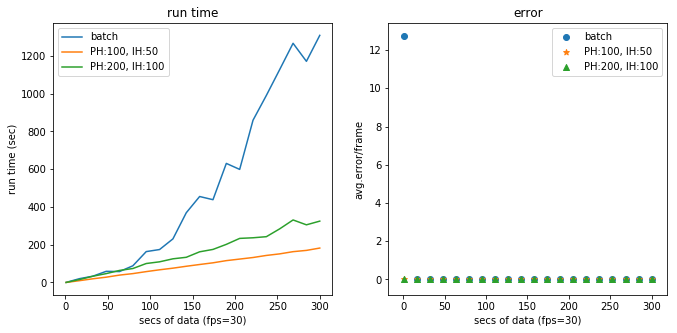

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))

ax1.plot(num_secs,times,label='batch')
ax1.plot(num_secs,times_100,label = 'PH:100, IH:50')
ax1.plot(num_secs,times_200,label = 'PH:200, IH:100')
ax1.legend()
ax1.set_xlabel('secs of data (fps=30)')
ax1.set_ylabel('run time (sec)')
ax1.set_title('run time')

ax2.scatter(num_secs,error,label='batch')
ax2.scatter(num_secs,error_100,marker='*',label = 'PH:100, IH:50')
ax2.scatter(num_secs,error_200,marker='^',label = 'PH:200, IH:100')
ax2.legend()
ax2.set_xlabel('secs of data (fps=30)')
ax2.set_ylabel('avg.error/frame')
ax2.set_title('error')

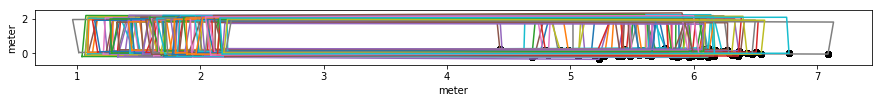

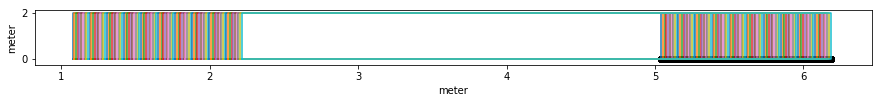

In [145]:
D = Y1[100:200,:]
fig, ax = plt.subplots(figsize=(15,1))
for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show()
D = Yre[100:200,:]
fig, ax = plt.subplots(figsize=(15,1))
for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show()

In [48]:
# check consistency of acceleration/theta for minibatches on synthetic data

import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)

# receding horizon approach
PH = 100 # optimize over Prediction Horizon frames
IH = 50 # implementation horizon
fps = 30
num_sec = 20

# generate synthetic data
n = int(num_sec*fps) # frames

timestamps, Y = opt.create_synth_data(n)
notNan = ~np.isnan(np.sum(Y,axis=-1))

w,l = opt.estimate_dimensions(Y[:100,:],timestamps[:100]) # use some data to estimate vehicle dimensions
print('estimated w:',w,'l:',l)

start = time.time()
Yre,a_arr,x_arr,v_arr,theta_arr = opt.receding_horizon_opt(Y,timestamps,w,l,n,PH,IH)
end = time.time()

print('run time: ',end-start,'correction/frame: ',LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan))


estimated w: 1.9705144884495036 l: 4.010601123440583
0 / 600
50 / 600
100 / 600
150 / 600
200 / 600
250 / 600
300 / 600
350 / 600
400 / 600
450 / 600
500 / 600
run time:  19.61164689064026 correction/frame:  0.026481489367053863


(600,)

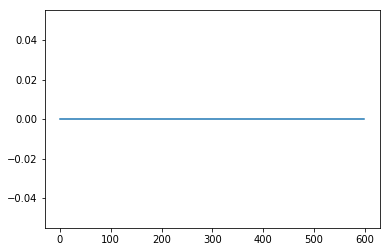

In [50]:
from matplotlib import cm
color=cm.rainbow(np.linspace(0,1,n))

for each car i
    plt.plot(xxx, color = color[i%n])
